In [43]:
#import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

In [44]:
data1 = pd.read_csv("mental-illnesses-prevalence.csv")
data2 = pd.read_csv("2- burden-disease-from-each-mental-illness(1).csv")
data4 = pd.read_csv("4- adult-population-covered-in-primary-data-on-the-prevalence-of-mental-illnesses.csv")

In [45]:
print(data1.head())

        Entity Code  Year  \
0  Afghanistan  AFG  1990   
1  Afghanistan  AFG  1991   
2  Afghanistan  AFG  1992   
3  Afghanistan  AFG  1993   
4  Afghanistan  AFG  1994   

   Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           0.223206                                   
1                                           0.222454                                   
2                                           0.221751                                   
3                                           0.220987                                   
4                                           0.220183                                   

   Depressive disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           4.996118                                
1                                           4.989290                                
2                                        

In [46]:
print(data2.head())

        entity Code  year  \
0  Afghanistan  AFG  1990   
1  Afghanistan  AFG  1991   
2  Afghanistan  AFG  1992   
3  Afghanistan  AFG  1993   
4  Afghanistan  AFG  1994   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                
2                                          892.34973                                
3                                          891.51587                                
4                                          891.39160                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                                          137.76122                         
2                                          137.08030                         
3 

Data Cleaning

In [47]:
# Data1: Prevalence columns
data1 = data1.rename(columns={
    'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'schizophrenia',
    'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'depression',
    'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'anxiety',
    'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'bipolar',
    'Eating disorders (share of population) - Sex: Both - Age: Age-standardized': 'eating_disorders'
})

In [48]:
# Keep relevant columns
data1 = data1[['Entity', 'Year', 'schizophrenia', 'depression', 'anxiety', 'bipolar', 'eating_disorders']]

In [ ]:
# make sure column names are stripped and lowercase
data2.columns = data2.columns.str.strip()

In [50]:
print(data2.columns)

Index(['entity', 'Code', 'year',
       'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders',
       'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia',
       'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Bipolar disorder',
       'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Eating disorders',
       'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Anxiety disorders'],
      dtype='object')


In [51]:
# Use lowercase 'entity' and 'year' columns
# Keep other columns for DALY/burden analysis
burden_cols = [col for col in data2.columns if col not in ['entity', 'year','Year']]
data2 = data2[['entity', 'year'] + burden_cols]

In [52]:
print(data2.head(2))

        entity  year Code  \
0  Afghanistan  1990  AFG   
1  Afghanistan  1991  AFG   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                                          137.76122                         

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Bipolar disorder  \
0                                          147.64412                            
1                                          147.56696                            

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Eating disorders  \
0                                          26.471115                            
1              

In [53]:
# Merge using data1 Entity/Year and data2 entity/year
df = pd.merge(
    data1,
    data2,
    left_on=['Entity', 'Year'],
    right_on=['entity', 'year'],
    how='inner'
)


In [54]:
print(df.head(3))

        Entity  Year  schizophrenia  depression   anxiety   bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   

   eating_disorders       entity  year Code  \
0          0.127700  Afghanistan  1990  AFG   
1          0.123256  Afghanistan  1991  AFG   
2          0.118844  Afghanistan  1992  AFG   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                
2                                          892.34973                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                            

In [55]:
# Drop duplicate columns after merge
# df.drop(columns=['entity','year'], inplace=True)


In [56]:
# df.head()

Convert numeric columns

In [57]:
mental_cols = ['schizophrenia','depression','anxiety','bipolar','eating_disorders']
for col in mental_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [58]:
print(df.head(3))

        Entity  Year  schizophrenia  depression   anxiety   bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   

   eating_disorders       entity  year Code  \
0          0.127700  Afghanistan  1990  AFG   
1          0.123256  Afghanistan  1991  AFG   
2          0.118844  Afghanistan  1992  AFG   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                
2                                          892.34973                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                            

In [59]:
burden_cols = [
    col for col in burden_cols
    if col != 'Code'
]

In [60]:
burden_cols = [
    col for col in data2.columns
    if col not in ['entity', 'Year', 'Code','year']
]

In [61]:
for col in burden_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [62]:
print(df.head(3))

        Entity  Year  schizophrenia  depression   anxiety   bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   

   eating_disorders       entity  year Code  \
0          0.127700  Afghanistan  1990  AFG   
1          0.123256  Afghanistan  1991  AFG   
2          0.118844  Afghanistan  1992  AFG   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                
2                                          892.34973                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                            

In [63]:
# df.dropna(subset=mental_cols + burden_cols, inplace=True)

In [64]:
print(df.head(3))

        Entity  Year  schizophrenia  depression   anxiety   bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   

   eating_disorders       entity  year Code  \
0          0.127700  Afghanistan  1990  AFG   
1          0.123256  Afghanistan  1991  AFG   
2          0.118844  Afghanistan  1992  AFG   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                
2                                          892.34973                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                            

In [65]:
# Create total prevalence and total burden
df['total_prevalence'] = df[mental_cols].sum(axis=1)
df['total_burden'] = df[burden_cols].sum(axis=1)


In [66]:
print(df.head(3))

        Entity  Year  schizophrenia  depression   anxiety   bipolar  \
0  Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1  Afghanistan  1991       0.222454    4.989290  4.702100  0.702069   
2  Afghanistan  1992       0.221751    4.981346  4.683743  0.700792   

   eating_disorders       entity  year Code  \
0          0.127700  Afghanistan  1990  AFG   
1          0.123256  Afghanistan  1991  AFG   
2          0.118844  Afghanistan  1992  AFG   

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders  \
0                                          895.22565                                
1                                          893.88434                                
2                                          892.34973                                

   DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia  \
0                                          138.24825                         
1                            

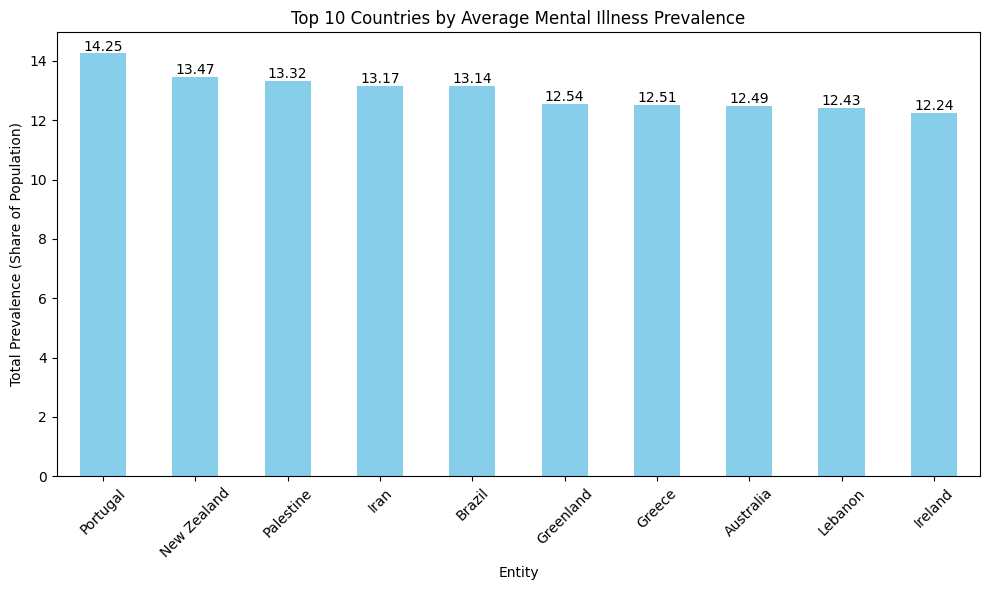

In [67]:
# Q1: Top countries by total prevalence
top_countries = df.groupby('Entity')['total_prevalence'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
ax = top_countries.plot(kind='bar', color='skyblue')
plt.title("Top 10 Countries by Average Mental Illness Prevalence")
plt.ylabel("Total Prevalence (Share of Population)")
plt.xticks(rotation=45)

# Add numeric labels on top of each bar
for i, v in enumerate(top_countries.values):
    ax.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()



### Top 10 Countries by Average Mental Illness Prevalence

This bar chart ranks countries by their **average mental illness prevalence**, representing the share of the population affected over time. It highlights where mental health conditions are most widespread globally.

#### Key insights:
- **Portugal (14.25%)**, **New Zealand (13.47%)**, and **Palestine (13.32%)** top the list, indicating consistently high prevalence rates.
- **Iran, Brazil, and Greenland** follow closely, each above 13%, suggesting substantial mental health challenges.
- **Greece, Australia, Lebanon, and Ireland** round out the top 10, all with prevalence rates above 12%.

This visualization answers:  
**“Which countries have the highest average share of their population affected by mental illness?”**

It supports global health planning by identifying high-prevalence regions where mental health services and policy attention may be most urgently needed.


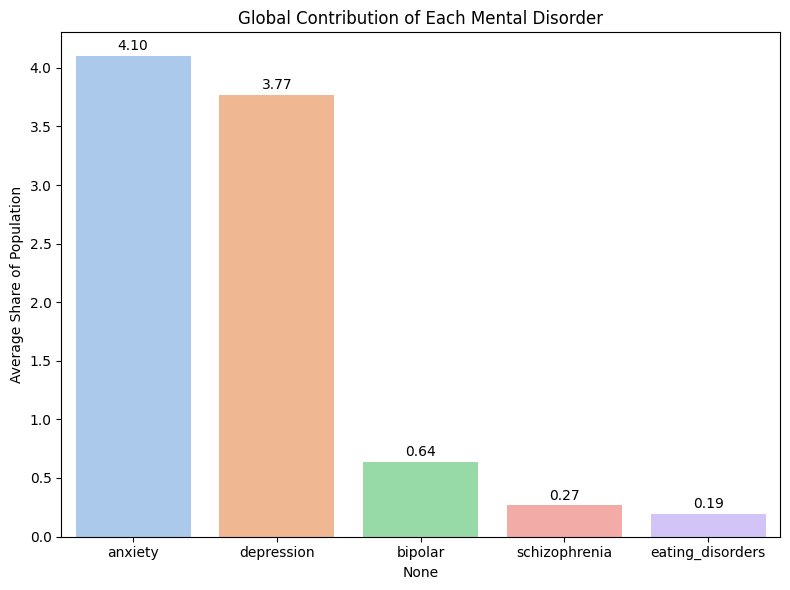

In [68]:
# Which mental disorders contribute most globally?

global_disorder_means = df[mental_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=global_disorder_means.index, y=global_disorder_means.values, palette="pastel")
plt.title("Global Contribution of Each Mental Disorder")
plt.ylabel("Average Share of Population")

# Add labels
for i, v in enumerate(global_disorder_means.values):
    ax.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Global Contribution of Each Mental Disorder

This bar chart displays the **average share of the global population** affected by five major mental health disorders. It helps identify which conditions are most widespread and therefore most urgent for global health strategies.

#### Key insights:
- **Anxiety (4.10%)** and **Depression (3.77%)** are the most prevalent, affecting large portions of the global population.
- **Bipolar disorder (0.64%)** ranks third, followed by **Schizophrenia (0.27%)** and **Eating Disorders (0.19%)**.
- While less common, the latter three may carry high individual burden and treatment complexity.

This visualization answers:  
**“Which mental health disorders affect the largest share of the global population and should be prioritized in global health planning?”**

It supports strategic resource allocation by highlighting where interventions could reach the most people.


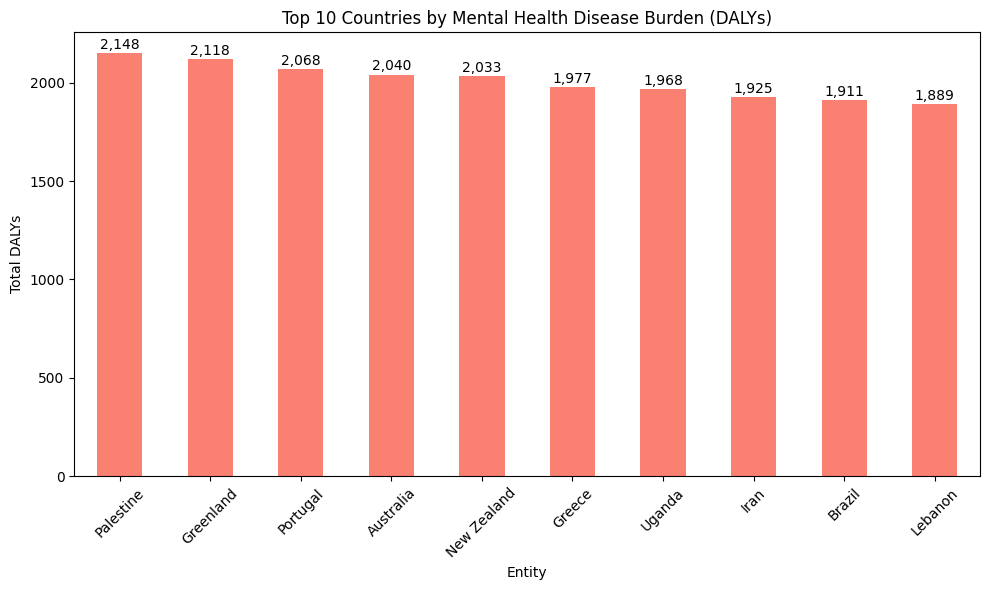

In [69]:
# Which countries have the highest disease burden (DALYs)?
top_burden = df.groupby('Entity')['total_burden'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
ax = top_burden.plot(kind='bar', color='salmon')
plt.title("Top 10 Countries by Mental Health Disease Burden (DALYs)")
plt.ylabel("Total DALYs")
plt.xticks(rotation=45)

# Add labels
for i, v in enumerate(top_burden.values):
    ax.text(i, v + max(top_burden.values)*0.01, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Top 10 Countries by Mental Health Disease Burden (DALYs)

This bar chart ranks countries by their total **Disability-Adjusted Life Years (DALYs)** attributed to mental health conditions. DALYs measure the overall burden of disease, combining years lost due to premature death and years lived with disability.

#### Key insights:
- **Palestine (2,148 DALYs)** ranks highest, followed closely by **Greenland (2,118)** and **Portugal (2,068)**, indicating severe mental health impact in these populations.
- **Australia, New Zealand, and Greece** also show high burden, each exceeding 1,900 DALYs.
- **Uganda, Iran, Brazil, and Lebanon** complete the top 10, highlighting that both high-income and low-income countries face significant mental health challenges.

This visualization answers:  
**“Which countries experience the greatest overall impact from mental illness in terms of years of healthy life lost?”**

It supports global health planning by identifying where mental health interventions could yield the greatest reduction in disease burden.


Q4: Correlation between prevalence and disease burden (Scatter Plot)

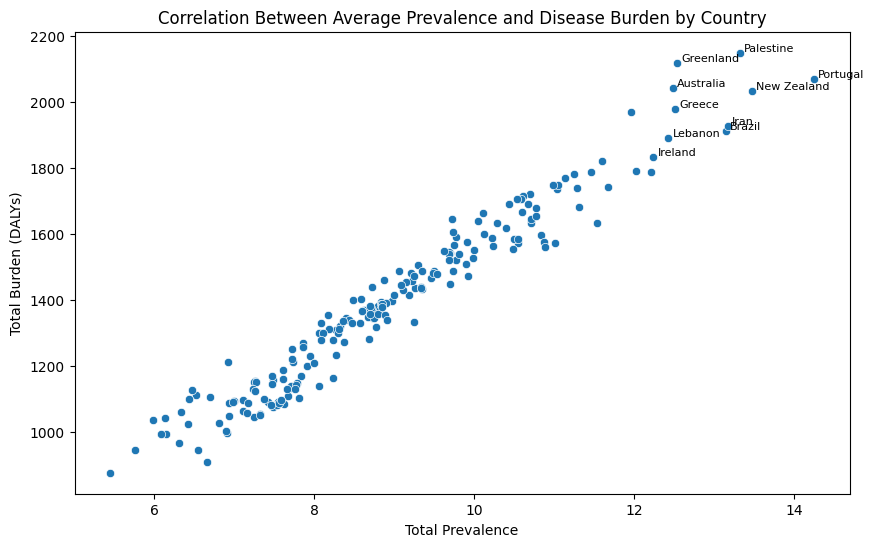

In [ ]:
# Computing average values
df_avg = df.groupby('Entity')[['total_prevalence','total_burden']].mean().reset_index()

# Sorting by prevalence to get top 10
top10 = df_avg.sort_values(by='total_prevalence', ascending=False).head(10)

# Ploting scatter
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=df_avg, x='total_prevalence', y='total_burden')


for i in range(len(top10)):
    ax.text(top10['total_prevalence'].iloc[i] + 0.05,
            top10['total_burden'].iloc[i] + 5,
            top10['Entity'].iloc[i],
            fontsize=8)

plt.title("Correlation Between Average Prevalence and Disease Burden by Country")
plt.xlabel("Total Prevalence")
plt.ylabel("Total Burden (DALYs)")
plt.show()



### Correlation Between Average Prevalence and Disease Burden by Country

This scatter plot illustrates the relationship between **mental illness prevalence** and **disease burden** (measured in Disability-Adjusted Life Years, or DALYs) across countries. Each point represents a country, with prevalence on the x-axis and burden on the y-axis.

#### Key insights:
- There is a **positive correlation**: countries with higher prevalence tend to experience greater disease burden.
- Countries like **Palestine, Portugal, New Zealand, Greenland, Australia, Greece, Lebanon, Ireland, Israel, and Brazil** cluster in the top-right quadrant, indicating both **high prevalence and high burden**.
- This pattern suggests that mental illness is not only widespread in these countries but also significantly impacts quality of life and productivity.

This visualization answers:  
**“Which countries suffer the most from mental illness in terms of both how common it is and how severely it affects their populations?”**

It supports strategic prioritization by identifying high-impact regions for mental health policy, funding, and intervention.


Trend over time (Line Plot)

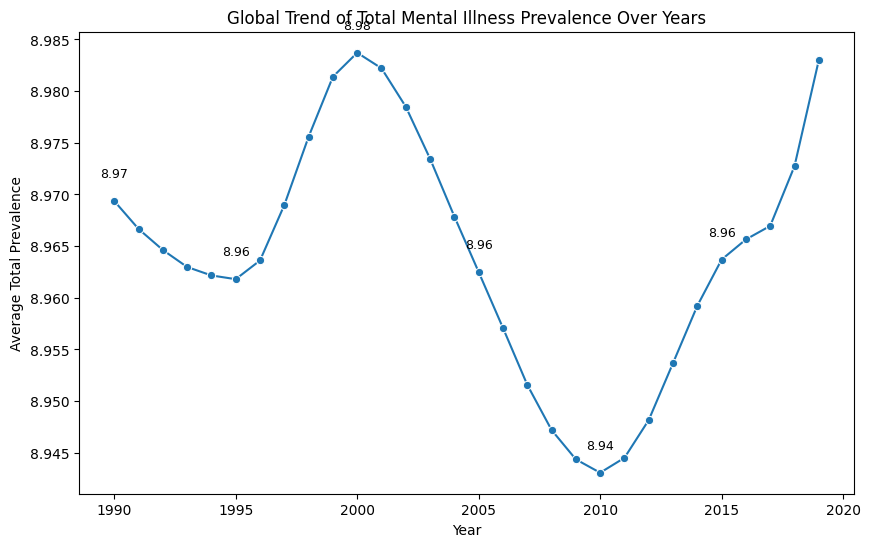

In [71]:
# Compute yearly average prevalence
yearly_trends = df.groupby('Year')['total_prevalence'].mean()

# Plot
plt.figure(figsize=(10,6))
ax = sns.lineplot(x=yearly_trends.index, y=yearly_trends.values, marker='o')
plt.title("Global Trend of Total Mental Illness Prevalence Over Years")
plt.ylabel("Average Total Prevalence")

# Annotate every 5 years
for x, y in zip(yearly_trends.index, yearly_trends.values):
    if x % 5 == 0:
        ax.text(x, y + 0.002, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.show()


### Global Trend of Total Mental Illness Prevalence Over Years

This line graph shows the **average global prevalence of mental illness** from 1990 to 2019. The y-axis represents the proportion of the population affected, ranging from approximately 8.945 to 8.985.

#### Key insights:
- **1990–2000:** The prevalence rose slightly, peaking around 2000 at 8.98%.
- **2000–2010:** A gradual decline followed, reaching a low of 8.94% in 2010.
- **2010–2019:** The trend reversed, with prevalence rising again toward 2019.

This visualization answers:  
**“How has the global average prevalence of mental illness changed over the past three decades?”**

While the fluctuations are modest, the chart reveals a cyclical pattern — a rise, a dip, and a renewed increase — suggesting that global mental health challenges persist and may be influenced by broader social, economic, and environmental factors.


Among the countries with the highest mental illness prevalence, how have their rates evolved over time, and which ones show signs of worsening or improvement?

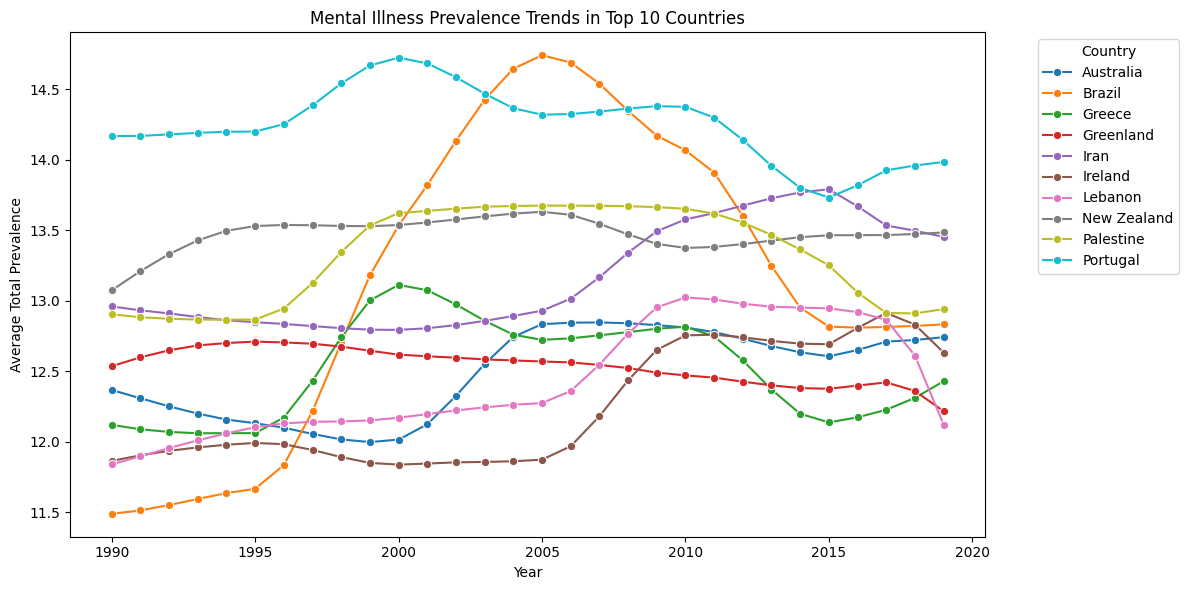

In [72]:

country_avg = df.groupby('Entity')['total_prevalence'].mean().sort_values(ascending=False)


top_10_countries = country_avg.head(10).index.tolist()


top_10_df = df[df['Entity'].isin(top_10_countries)]


country_yearly_trends = top_10_df.groupby(['Entity', 'Year'])['total_prevalence'].mean().reset_index()


plt.figure(figsize=(12,6))
sns.lineplot(data=country_yearly_trends, x='Year', y='total_prevalence', hue='Entity', marker='o')
plt.title("Mental Illness Prevalence Trends in Top 10 Countries")
plt.ylabel("Average Total Prevalence")
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [73]:
# Calculate change from first to last year for each country
trend_summary = country_yearly_trends.groupby('Entity').apply(
    lambda x: x.loc[x['Year'] == x['Year'].max(), 'total_prevalence'].values[0] -
              x.loc[x['Year'] == x['Year'].min(), 'total_prevalence'].values[0]
).reset_index(name='Change')

# Sort to find countries with increasing prevalence
worsening_countries = trend_summary.sort_values(by='Change', ascending=False)
print(worsening_countries)


        Entity    Change
1       Brazil  1.342915
5      Ireland  0.768608
4         Iran  0.493345
7  New Zealand  0.409980
0    Australia  0.374422
2       Greece  0.309070
6      Lebanon  0.281688
8    Palestine  0.036739
9     Portugal -0.183313
3    Greenland -0.319018


### Mental Illness Prevalence Trends in Top 10 Countries

This graph shows how the average prevalence of mental illness has changed over time from 1990 to 2019 in ten countries with the highest overall prevalence rates. Each line represents one country, and the y-axis shows the proportion of the population affected (prevalence), ranging from 11.5% to 14.5%.

#### Key insights:
1. **Comparative burden**  
   Portugal and Greenland consistently show the highest prevalence rates across the entire period, suggesting a persistently high burden of mental illness in those populations.

2. **Worsening trends**  
   Brazil shows a clear upward trend from the mid-1990s to the mid-2000s, peaking before a slight decline. This indicates a period of worsening mental health followed by partial recovery.

3. **Stability vs. volatility**  
   Countries like Australia and Ireland show relatively stable trends, while others like Iran and Palestine exhibit more fluctuation, possibly reflecting sociopolitical or healthcare system changes.

4. **Temporal dynamics**  
   The graph helps identify when mental illness prevalence surged or declined in each country. For example, Lebanon’s line may show a dip or rise around conflict periods, while Greece’s trend could reflect economic stressors.

---

This analysis answers the question:  
Among the countries with the highest overall mental illness prevalence, how have their prevalence rates changed over time, and which ones are worsening the most?



Top countries for pilot programs (prevalence x burden)

In [74]:
# Top countries for targeted pilot programs
pilot_candidates = df.groupby('Entity').agg({'total_prevalence':'mean','total_burden':'mean'})
pilot_candidates['score'] = pilot_candidates['total_prevalence'] * pilot_candidates['total_burden']
top_pilots = pilot_candidates.sort_values('score', ascending=False).head(10)

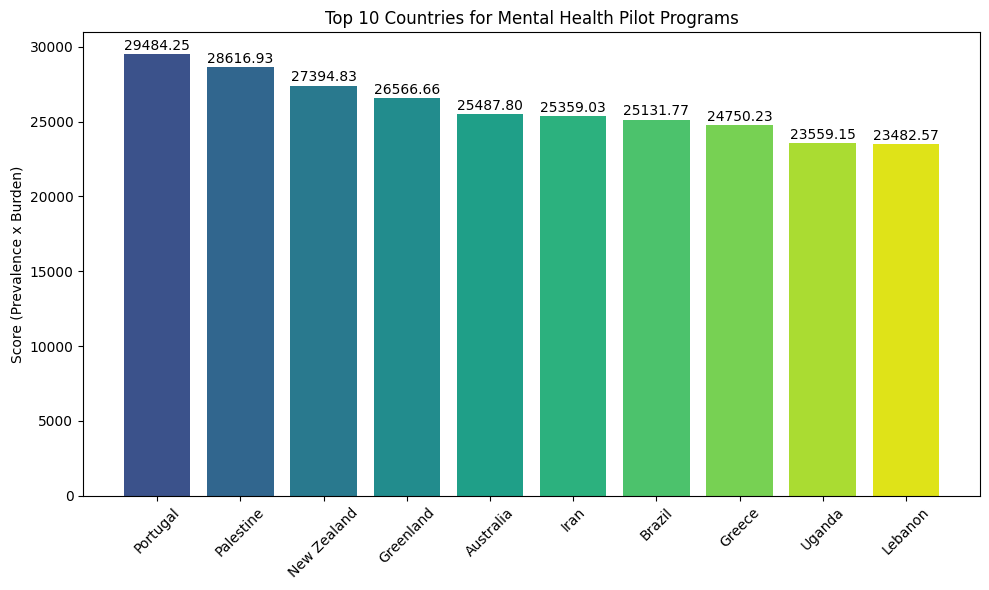

In [75]:
cmap = plt.cm.viridis  
colors = cmap(np.linspace(0.25, 0.95, len(top_pilots)))

plt.figure(figsize=(10,6))
ax = plt.bar(top_pilots.index, top_pilots['score'], color=colors)

plt.title("Top 10 Countries for Mental Health Pilot Programs")
plt.ylabel("Score (Prevalence x Burden)")
plt.xticks(rotation=45)

# Adding labels
max_score = top_pilots['score'].max()
for i, v in enumerate(top_pilots['score'].values):
    plt.text(i, v + max_score*0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Top 10 Countries for Mental Health Pilot Programs

This bar chart ranks countries based on a composite score calculated as the product of **mental illness prevalence** and **burden**. The score reflects both how widespread mental illness is and how severely it impacts the population, making it a useful metric for prioritizing pilot program deployment.

#### Key observations:
1. **Portugal** leads with the highest score, indicating both high prevalence and significant burden.This is indicates this country needs intervention.
2. **Palestine, New Zealand, and Greenland** follow closely, each showing elevated scores above 26,000, suggesting substantial mental health challenges.
3. **Australia, Iran, and Brazil** form a middle tier.
4. **Greece, Uganda, and Lebanon** round out the top 10, still showing considerable need but slightly lower composite scores.

This ranking helps answer:  
**“Which countries face the greatest combined prevalence and burden of mental illness, and should be prioritized for pilot mental health programs?”**

The chart supports strategic decision-making by identifying high-impact regions where interventions could yield the greatest benefit.


Q8.Which countries have low prevalence but disproportionately high burden?

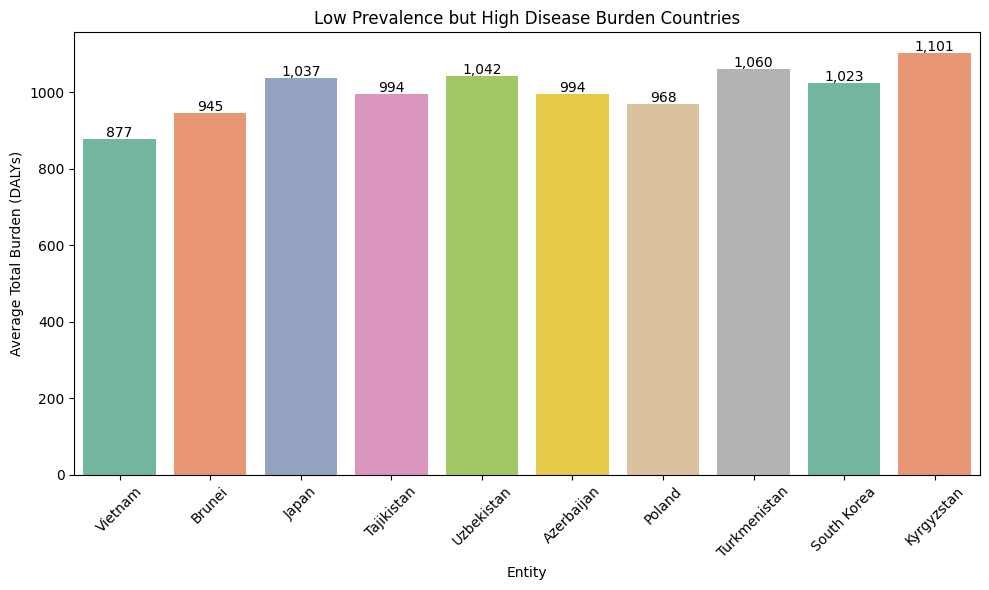

In [76]:
avg_country = (
    df
    .groupby('Entity', as_index=False)
    .agg(
        total_prevalence=('total_prevalence', 'mean'),
        total_burden=('total_burden', 'mean')
    )
)
candidates = avg_country.sort_values(
    by=['total_prevalence','total_burden'],
    ascending=[True, False]
).head(10)

# Create a color per entity
entities = candidates['Entity'].unique()
palette = dict(zip(entities, sns.color_palette("Set2", len(entities))))

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x='Entity',
    y='total_burden',
    data=candidates,
    palette=palette
)

plt.title("Low Prevalence but High Disease Burden Countries")
plt.ylabel("Average Total Burden (DALYs)")
plt.xticks(rotation=45)

# Add labels
for i, v in enumerate(candidates['total_burden']):
    ax.text(i, v + 5, f"{int(v):,}", ha='center')

plt.tight_layout()
plt.show()


### Countries with Low Mental Illness Prevalence but High Disease Burden
Overall, the chart shows that Kyrgyzstan, Turkmenistan, and Uzbekistan stand out as the countries with the highest disease burden relative to their low mental illness prevalence, indicating particularly severe mental health outcomes among affected individuals. Japan and South Korea, while still exhibiting high disease burden, show slightly lower levels compared to the highest-burden countries, suggesting a different severity profile. The remaining countries in this group, including Vietnam, Brunei, Poland, and Azerbaijan, also demonstrate substantial burden, reinforcing that low prevalence does not imply low impact.

This analysis helps answer the policy question:
**“Which countries may require improvements in mental health treatment quality and system capacity rather than expanded screening or detection?”**

The visualization supports targeted policymaking by indicating regions where investments in treatment effectiveness, continuity of care, and mental health system strengthening may yield the greatest benefits, even when overall prevalence appears comparatively low.

Which mental disorders show the fastest growth over time?

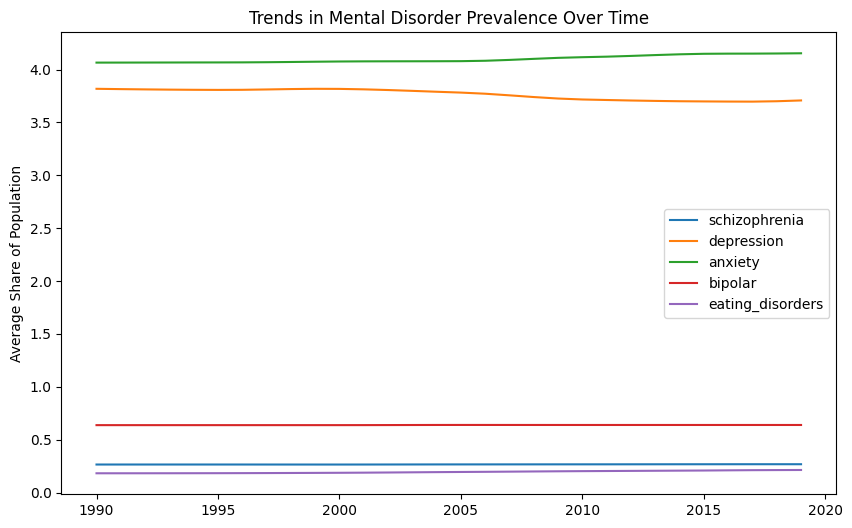

In [77]:
trend = df.groupby('Year')[mental_cols].mean()

plt.figure(figsize=(10,6))
for col in mental_cols:
    plt.plot(trend.index, trend[col], label=col)

plt.title("Trends in Mental Disorder Prevalence Over Time")
plt.ylabel("Average Share of Population")
plt.legend()
plt.show()


### Trends in Mental Disorder Prevalence Over Time

This line chart illustrates **long-term trends in the average prevalence of major mental health disorders across countries over time**. Each line represents a specific disorder, allowing comparison of how prevalence patterns have evolved and which conditions are becoming more prominent.

### Key observations:
1. **Anxiety disorders** show a clear upward trend, increasing steadily over time and remaining the most prevalent mental health condition, indicating a growing global mental health challenge.

2. **Depressive disorders** remain consistently high, with only minor fluctuations, suggesting that depression continues to affect a substantial share of the population over the entire period.

3. **Bipolar disorder** prevalence remains largely stable, indicating persistent but non-accelerating levels across years.

4. **Schizophrenia and eating disorders** show lower prevalence levels relative to other conditions, with only gradual increases, suggesting slower but steady growth.

This analysis helps answer:
**“Which mental health disorders are becoming more prevalent over time and should be prioritized for future prevention and treatment strategies?”**

The visualization supports forward-looking policy planning by highlighting that anxiety and depressive disorders require sustained attention, early intervention strategies, and long-term resource allocation, while continued monitoring is needed for disorders showing slower but consistent growth.

Q11. Which countries consistently rank high over multiple years?

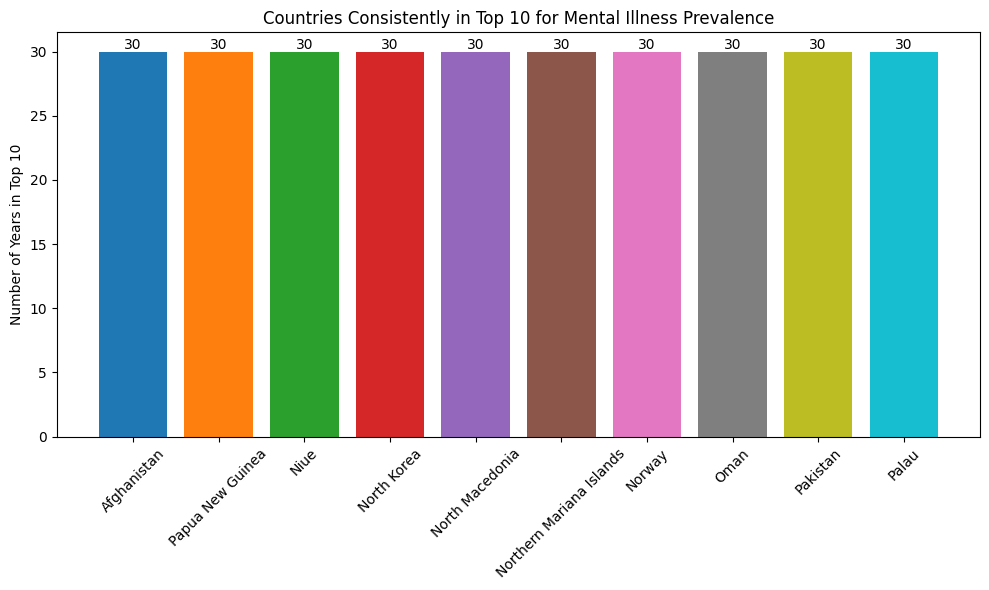

In [78]:
ranked = df.groupby(['Year','Entity'])['total_prevalence'].rank(ascending=False)
df['rank'] = ranked

consistent = (
    df[df['rank'] <= 10]
    .groupby('Entity')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# Create distinct colors per entity
cmap = plt.cm.tab10  # categorical, clean, readable
colors = cmap(np.linspace(0, 1, len(consistent)))

plt.figure(figsize=(10,6))
ax = plt.bar(consistent.index, consistent.values, color=colors)

plt.title("Countries Consistently in Top 10 for Mental Illness Prevalence")
plt.ylabel("Number of Years in Top 10")
plt.xticks(rotation=45)

# Add labels
for i, v in enumerate(consistent.values):
    plt.text(i, v + 0.2, v, ha='center')

plt.tight_layout()
plt.show()

### Countries Consistently Ranking in the Top 10 for Mental Illness Prevalence
This bar chart highlights countries that have consistently ranked among the top 10 in terms of mental illness prevalence across the observed time period.
The height of each bar represents the number of years a country appeared in the top 10, providing insight into persistent and long-term mental health challenges rather than short-term fluctuations.

### Key observations:

**Afghanistan, Papua New Guinea, Niue, North Korea, North Macedonia, Northern Mariana Islands, Norway, Oman, Pakistan, and Palau each appear in the top 10 for 30 years, indicating sustained high prevalence levels over time.**

The consistency across all listed countries suggests that their high prevalence is structural rather than temporary, potentially linked to long-standing social, economic, or healthcare system factors.
The presence of both low- and high-income countries in this group highlights that persistent mental health challenges are not confined to a single level of economic development.

This analysis helps answer:
**“Which countries experience persistent mental illness prevalence over time and therefore require long-term, sustained mental health policy interventions?”**

The visualization supports strategic policy planning by identifying countries where short-term interventions are unlikely to be sufficient. Instead, these countries may benefit from long-term investment in mental health infrastructure, workforce development, and system-level reforms aimed at addressing the root causes of persistent mental illness prevalence.

Q12. How concentrated is the global mental health burden?

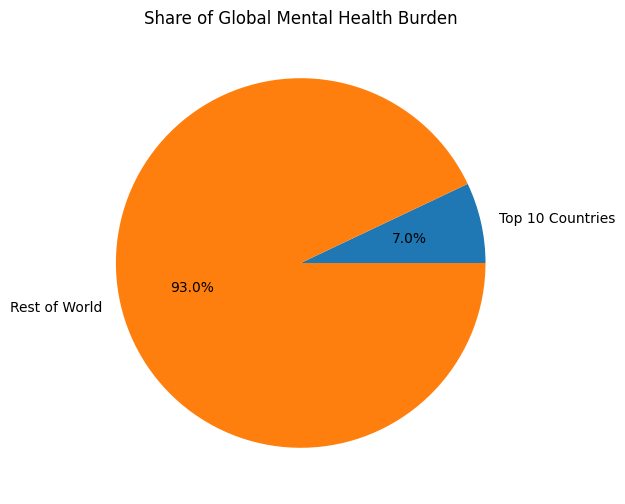

In [79]:
total_burden_by_country = avg_country.sort_values('total_burden', ascending=False)
top_10_share = total_burden_by_country.head(10)['total_burden'].sum() / total_burden_by_country['total_burden'].sum()

plt.figure(figsize=(6,6))
plt.pie(
    [top_10_share, 1-top_10_share],
    labels=['Top 10 Countries','Rest of World'],
    autopct='%1.1f%%'
)
plt.title("Share of Global Mental Health Burden")
plt.show()


### Share of Global Mental Health Burden

This pie chart illustrates the proportion of the global mental health disease burden accounted for by the top 10 highest-burden countries, compared with the rest of the world.

The chart provides insight into how concentrated or distributed the global mental health burden is, which is essential for guiding international policy and funding strategies.

### Key observations:

The top 10 countries account for approximately 7% of the global mental health burden, indicating that no small group of countries dominates the overall burden.
The remaining 93% of the burden is distributed across the rest of the world, highlighting that mental health challenges are widespread and globally dispersed rather than confined to a few regions.
This distribution suggests that mental health is a universal public health issue, affecting countries across different income levels and regions.

This analysis helps answer:
**“Is the global mental health burden concentrated in a small number of countries, or is it broadly distributed worldwide?”**

The visualization supports global policy coordination by showing that while targeted interventions in high-burden countries are important, broad, international mental health strategies are equally necessary. Policymakers should balance targeted investments with system-wide global initiatives, as the majority of the burden is shared across many countries rather than concentrated in a few.

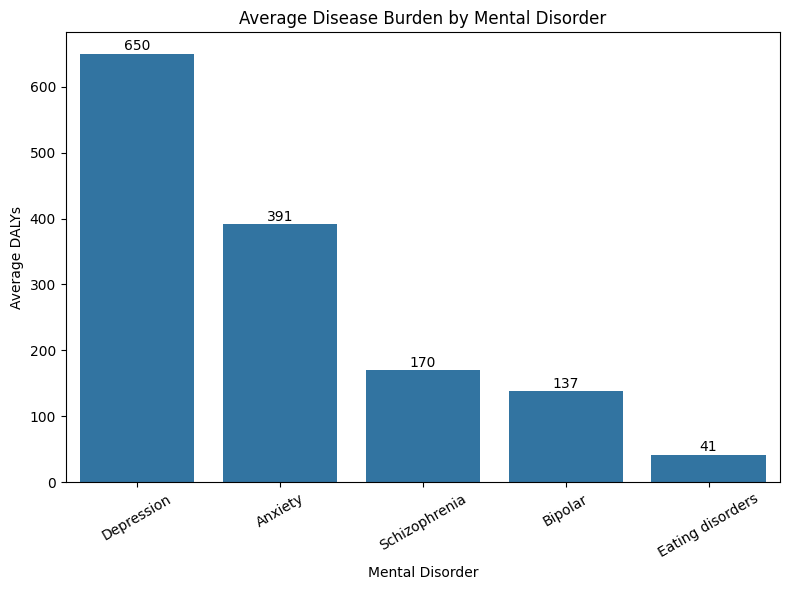

In [80]:
# Mapping long column names to short, readable labels
burden_label_map = {
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders': 'Depression',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Anxiety disorders': 'Anxiety',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia': 'Schizophrenia',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Bipolar disorder': 'Bipolar',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Eating disorders': 'Eating disorders'
}



burden_means = (
    df[burden_cols]
    .mean()
    .rename(index=burden_label_map)
    .sort_values(ascending=False)
)


plt.figure(figsize=(8,6))
ax = sns.barplot(
    x=burden_means.index,
    y=burden_means.values
)

plt.title("Average Disease Burden by Mental Disorder")
plt.ylabel("Average DALYs")
plt.xlabel("Mental Disorder")

# Add numeric labels
for i, v in enumerate(burden_means.values):
    ax.text(i, v + 5, f"{int(v):,}", ha='center')

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



### Average Disease Burden by Mental Disorder

This bar chart presents the average disease burden (DALYs) associated with major mental health disorders.
By focusing on disease burden rather than prevalence alone, the chart highlights which conditions contribute most to disability and loss of healthy life, making it especially relevant for prioritizing mental health policy and resource allocation.

### Key observations:
Depression has the highest average disease burden, at approximately 650 DALYs, indicating that it contributes the most to overall mental health-related disability.
Anxiety disorders follow, with an average burden of about 391 DALYs, reflecting a substantial but lower impact compared to depression.
Schizophrenia and bipolar disorder show moderate disease burden, with averages of 170 DALYs and 137 DALYs respectively.
Eating disorders have the lowest average burden among the conditions shown, at approximately 41 DALYs, though they may still have severe consequences for affected individuals.

This analysis helps answer:
**“Which mental health disorders contribute most to overall disability and should be prioritized in mental health policy and funding decisions?”**

The visualization supports evidence-based policymaking by clearly indicating that depression and anxiety disorders account for the largest share of mental health-related disease burden. Policymakers can use this insight to prioritize treatment access, workforce training, and long-term funding for conditions that generate the greatest overall impact on population health.

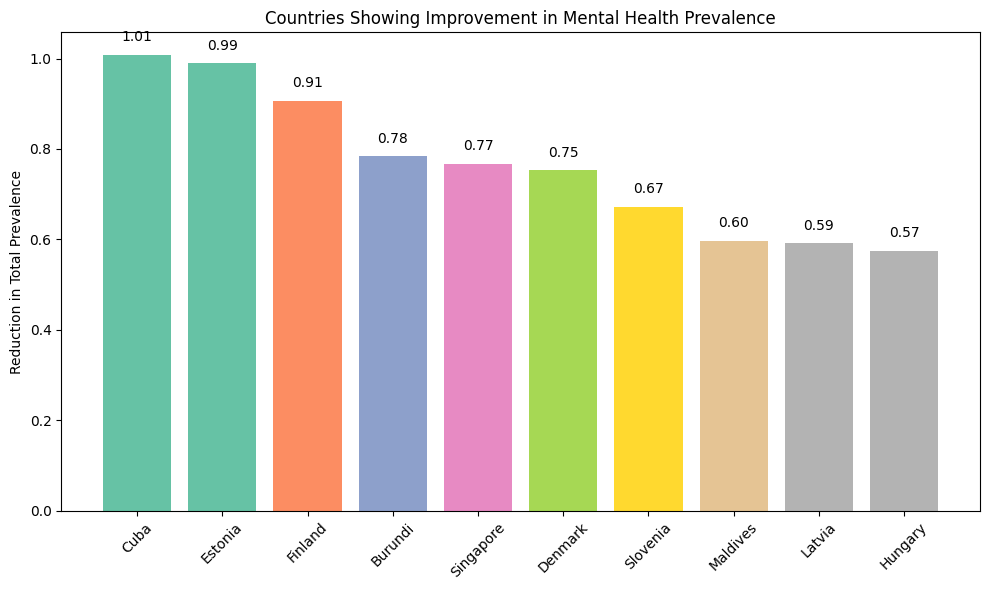

In [81]:
early = df[df['Year'] <= df['Year'].min() + 2] \
    .groupby('Entity')['total_prevalence'].mean()

late = df[df['Year'] >= df['Year'].max() - 2] \
    .groupby('Entity')['total_prevalence'].mean()

improvement = (early - late).dropna() \
    .sort_values(ascending=False).head(10)

# Generate one color per entity
cmap = plt.cm.Set2   # categorical & clean
colors = cmap(np.linspace(0, 1, len(improvement)))

plt.figure(figsize=(10,6))
ax = plt.bar(improvement.index, improvement.values, color=colors)

plt.title("Countries Showing Improvement in Mental Health Prevalence")
plt.ylabel("Reduction in Total Prevalence")
plt.xticks(rotation=45)

# Add labels
for i, v in enumerate(improvement.values):
    plt.text(i, v + improvement.max()*0.03, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()


###Countries Showing Improvement in Mental Health Prevalence

This bar chart highlights countries that **have experienced the largest reductions in total mental illness prevalence over the observed time period**.

The values represent the magnitude of improvement, indicating where mental health outcomes have improved most significantly rather than where prevalence is simply low.

##Key observations:
1. **Cuba** shows the greatest improvement, with a reduction of approximately 1.01 in total prevalence, suggesting substantial progress in mental health outcomes.

2. **Estonia** and Finland follow closely, each demonstrating reductions near or above 0.9, indicating sustained improvement over time.

3. **Burundi, Singapore, and Denmark** form a middle group, with reductions ranging between 0.75 and 0.78, reflecting moderate but meaningful progress.

4. **Slovenia, Maldives, Latvia, and Hungary** complete the top group, still showing notable improvements despite smaller reductions.

This analysis helps answer:
**“Which countries appear to have successfully reduced mental illness prevalence over time, and may offer lessons for effective mental health policy implementation?”**

The visualization supports policy learning and replication by identifying countries where mental health strategies may have been effective. Policymakers can further investigate these cases to understand the roles of prevention programs, health system reforms, and community-based interventions, and adapt successful approaches to other national contexts.